In [65]:
using Revise
using NonEquilibriumGreenFunction
using HssMatrices
using LinearAlgebra
using Makie
using CairoMakie
using StaticArrays
using LaTeXStrings

In [59]:
module Junction
using Revise
using NonEquilibriumGreenFunction
using LinearAlgebra
struct Parameters
    δt::Float64 #timestep
    T::Float64  #simulation length
    Γl::Float64 #left tunneling rate
    Γr::Float64 #right tunneling rate
    β::Float64  #inverse temperature
    ϕl # left phase
    ϕr # right phase
end
default_compression() = HssCompression(leafsize=32)
function Parameters(; δt, T, Γl=1, Γr=1, β=1, ϕl, ϕr)
    return Parameters(δt, T, Γl, Γr, β, ϕl, ϕr)
end
axis(p::Parameters) = 0:p.δt:p.T
function simulate_junction(p::Parameters)
    cpr = default_compression()
    #retarded
    Σ_R_right = dirac_kernel(Retarded(), axis(p), t -> -1im * p.Γr, compression=cpr)
    Σ_R_left = dirac_kernel(Retarded(), axis(p), t -> -1im * p.Γl, compression=cpr)
    Σ_R = Σ_R_left + Σ_R_right
    g = discretize_retardedkernel(axis(p), (t, tp) -> ComplexF64(-1im), compression=cpr, stationary=true)
    G_R = solve_dyson(g, g * Σ_R)
    #kinetic 
    ρ = discretize_acausalkernel(axis(p), (t, tp) -> thermal_kernel(t - tp, p.β) .|> ComplexF64,
        stationary=true, compression=cpr)
    coupling_left = dirac_kernel(Acausal(), axis(p), t -> sqrt(p.Γl)*exp(1im*p.ϕl(t)), compression=cpr)
    coupling_right = dirac_kernel(Acausal(), axis(p), t -> sqrt(p.Γr)*exp(1im*p.ϕr(t)), compression=cpr)
    Σ_K_left = coupling_left'*ρ*coupling_left
    Σ_K_right = coupling_right'*ρ*coupling_right
    Σ_K = Σ_K_left + Σ_K_right
    G_K = G_R*Σ_K*G_R'
    return (;G_R,G_K)
end
function dot_G_K(G::Kernel, p::Parameters)
    discretize_acausalkernel(axis(p), (t, tp) -> thermal_kernel(t - tp, p.β) * pauli(0) .|> ComplexF64,
        stationary=true, compression=default_compression())
end
end

Main.Junction

In [84]:
p = Junction.Parameters(δt=0.1, T=100, ϕl=t -> 0, ϕr=t -> 0);
println("N = $(Junction.axis(p)|> length)")
results = Junction.simulate_junction(p)

N = 1001


(G_R = Kernel{TrapzDiscretisation{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, HssMatrix{ComplexF64}, HssCompression{Float64, Int64}}, Retarded}(TrapzDiscretisation{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, HssMatrix{ComplexF64}, HssCompression{Float64, Int64}}(0.0:0.1:100.0, ComplexF64[0.0 - 1.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 - 0.9im 0.0 - 1.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; -5.448657147466867e-80 - 4.184892330779229e-79im -6.81082143447748e-80 - 5.23111541346467e-79im … 0.0 - 1.0im 6.134051482597886e-17 - 6.973993245345885e-17im; -4.358925717925458e-80 - 3.3479138646232296e-79im -5.448657147521943e-80 - 4.184892330771544e-79im … -1.6319992167878688e-16 - 0.9000000000000001im 0.0 - 1.0im], 1, HssCompression{Float64, Int64}(1.0e-6, 1.0e-6, 20, 32)), Retarded()), G_K = Kernel{TrapzDiscretisation{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int6

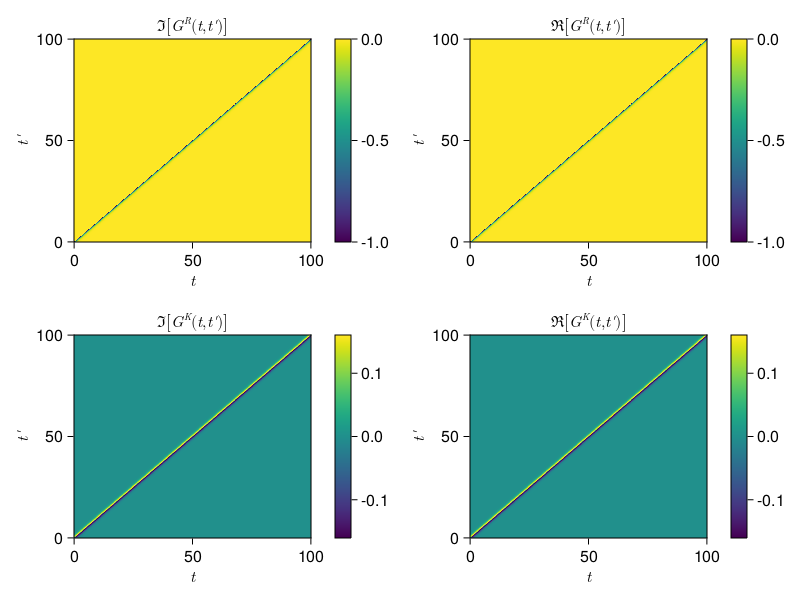

In [117]:
function plot_results_maps(results)
    f = Figure()
    #retarded Green function
    f_ax = Axis(f[1, 1], title=L" \Im \left[ G^R(t,t')\right]",xlabel=L"t", ylabel=L"t'")
    G_R = matrix(results[:G_R]) |> full
    ax = Junction.axis(p) |> collect
    im_G_R = imag.(G_R)
    hm = heatmap!(f_ax, ax,ax, im_G_R)
    Colorbar(f[1, 2], hm)
    f_ax = Axis(f[1, 3], title=L"\Re \left[ G^R(t,t')\right]",xlabel=L"t", ylabel=L"t'")
    re_G_R = real.(G_R)
    hm = heatmap!(f_ax, ax,ax, im_G_R)
    Colorbar(f[1, 4], hm)
    #Keldysh Green function
    f_ax = Axis(f[2, 1], title=L" \Im \left[ G^K(t,t')\right]",xlabel=L"t", ylabel=L"t'")
    G_K = matrix(results[:G_K]) |> full
    ax = Junction.axis(p) |> collect
    im_G_K = imag.(G_K)
    hm = heatmap!(f_ax, ax,ax, im_G_K)
    Colorbar(f[2, 2], hm)
    f_ax = Axis(f[2, 3], title=L"\Re \left[ G^K(t,t')\right]",xlabel=L"t", ylabel=L"t'")
    re_G_K = real.(G_K)
    hm = heatmap!(f_ax, ax,ax, im_G_K)
    Colorbar(f[2, 4], hm)

    f
end
if length(Junction.axis(p)) < 2001 
    plot_results_maps(results)
end

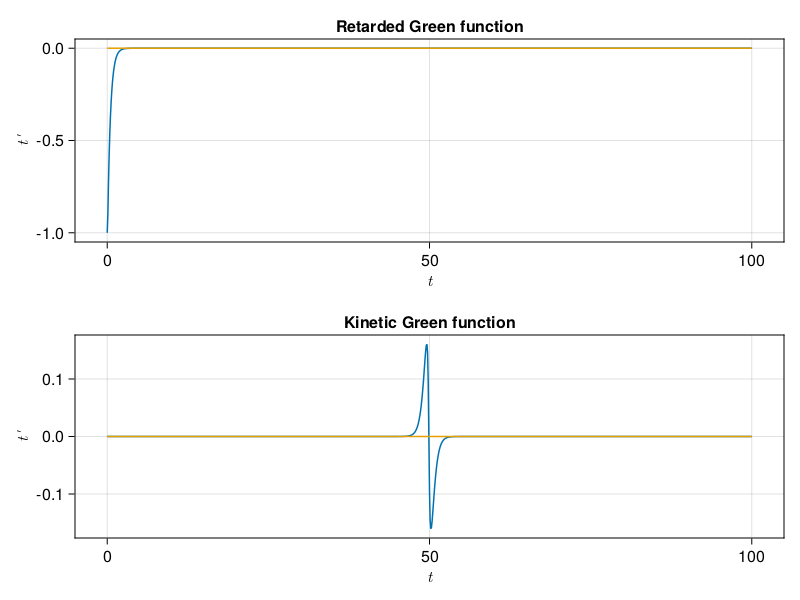

In [123]:
function plot_results(results)
    f = Figure()
    #retarded Green function
    f_ax = Axis(f[1, 1], title="Retarded Green function",xlabel=L"t", ylabel=L"t'")
    G_R = results[:G_R]
    ax = Junction.axis(p) |> collect
    im_G_R = reshape(imag.(vcat(discretization(G_R)[:, 1]...)), :)
    lines!(f_ax, ax, im_G_R)
    re_G_R = reshape(real.(vcat(discretization(G_R)[:, 1]...)), :)
    lines!(f_ax, ax, re_G_R)
    #Keldysh Green function
    G_K = results[:G_K]
    ax = Junction.axis(p) |> collect
    im_G_K = reshape(imag.(vcat(discretization(G_K)[:, length(ax) ÷ 2]...)), :)
    f_ax = Axis(f[2, 1], title="Kinetic Green function",xlabel=L"t", ylabel=L"t'")
    lines!(f_ax, ax, im_G_K)
    re_G_K = reshape(real.(vcat(discretization(G_K)[:, length(ax) ÷ 2]...)), :)
    lines!(f_ax, ax, re_G_K)
    f
end
plot_results(results)